In [65]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

# import about model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor
from sklearn.linear_model import LogisticRegression, Ridge, Lasso
from sklearn.svm import SVR
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.neighbors import KNeighborsRegressor

In [66]:
# heart_2020
heart_2020_cleaned = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2020/heart_2020_cleaned.csv')

# heart_2022
heart_2022 = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/2022/heart_2022_no_nans.csv')

# # heart
# heart = pd.read_csv('/Users/taijieshengwu/2024Research_SU/Data/heart.csv')

heart_2020_cleaned = heart_2020_cleaned.rename(columns={"HeartDisease":"output"})
heart_2022 = heart_2022.rename(columns={"HadHeartAttack":"output"})

In [ ]:
from scipy import sparse
def create_pipeline(X):
    # Determine feature types
    categorical_features = X.select_dtypes(include=['object', 'bool']).columns.tolist()
    categorical_features.remove('output')
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(), categorical_features)
        ]
    )
    
    print("X_tranformed shpe 0",X.shape)
    print("X_tranformad ndarry",X)
    # Fit the pipeline to the data
    X_transformed = preprocessor.fit_transform(X)
    
    
    # Generate new column names for one-hot encoded features
    encoded_categorical_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features)
    all_feature_names = numeric_features + list(encoded_categorical_features)
    
    print(len(all_feature_names)) # 154

    print("X_tranformed shpe 1",X_transformed.shape)
    print("X_tranformad ndarry",X_transformed)
    print("X_type",type(X_transformed))
    

    X_transformed = pd.DataFrame(X_transformed.toarray(),columns=all_feature_names)
    print("X_tranformed shpe 2",X_transformed.shape)
    
    X_transformed = pd.concat([X_transformed, X["output"].reset_index(drop=True)], axis=1)


    return X_transformed

# heart_2020 = create_pipeline(heart_2020_cleaned)
# print("heart_2020",heart_2020.head)

heart_2022_pro = create_pipeline(heart_2022)
print("heart_2020",heart_2022_pro.head)



In [78]:
heart_2022_pro.head()

,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,...,"TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",HighRiskLastYear_No,HighRiskLastYear_Yes,CovidPos_No,CovidPos_Tested positive using home test without a health professional,CovidPos_Yes,output
0,-0.014160,-0.514292,1.373428,-0.985904,-0.560199,-0.104105,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,No
1,-0.490020,-0.514292,-0.708924,0.701799,0.545644,0.224420,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,No
2,-0.490020,-0.514292,0.679311,1.358128,1.183918,0.459300,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,No
3,0.104805,-0.514292,1.373428,-0.048291,0.333198,0.407105,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,No
4,-0.133125,1.336949,-1.403041,-1.454710,-0.198619,0.675759,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,No


In [14]:
import numpy as np
import pandas as pd

def over_sampling(X, random_state=42):
    """
    Oversamples the minority class in the 'output' column to balance the classes.
    
    Parameters:
    X (DataFrame): The dataset containing the 'output' column.
    random_state (int): Seed used by the random number generator.
    
    Returns:
    X_resampled (DataFrame): Resampled dataset with balanced classes in the 'output' column.
    """
    np.random.seed(random_state)
    
    # Ensure 'output' column is present
    if 'output' not in X.columns:
        raise ValueError("The dataset must contain an 'output' column.")
    
    # Separate the majority and minority classes
    class_counts = X['output'].value_counts()
    majority_class = class_counts.idxmax()
    minority_class = class_counts.idxmin()
    
    X_majority = X[X['output'] == majority_class]
    X_minority = X[X['output'] == minority_class]
    
    # Calculate the number of samples to add to the minority class
    n_majority = len(X_majority)
    n_minority = len(X_minority)
    n_to_add = n_majority - n_minority
 
    indices_to_add = np.random.choice(X_minority.index, size=n_to_add, replace=True)
    X_oversampled = X_minority.loc[indices_to_add]
    X_resampled = pd.concat([X_majority, X_minority, X_oversampled])

    X_resampled = X_resampled.sample(frac=1, random_state=random_state).reset_index(drop=True)

    return X_resampled

print("Original heart_2020 shape:", heart_2020.shape)
print("Original 'output' class distribution:")
print(heart_2020['output'].value_counts())

heart_2020_resampled = over_sampling(heart_2020)

print("Resampled heart_2020 shape:", heart_2020_resampled.shape)
print("Resampled 'output' class distribution:")
print(heart_2020_resampled['output'].value_counts())

Original heart_2020 shape: (319795, 51)
Original 'output' class distribution:
output
No     292422
Yes     27373
Name: count, dtype: int64
Resampled heart_2020 shape: (584844, 51)
Resampled 'output' class distribution:
output
Yes    292422
No     292422
Name: count, dtype: int64


In [79]:
print("Original heart_2022 shape:", heart_2022_pro.shape)
print("Original 'output' class distribution:")
print(heart_2022_pro['output'].value_counts())

heart_2022_resampled = over_sampling(heart_2022_pro)

print("Resampled heart_2020 shape:", heart_2022_resampled.shape)
print("Resampled 'output' class distribution:")
print(heart_2022_resampled['output'].value_counts())

ouput_map = {
    'Yes':1,
    'No':0
}
heart_2022_resampled['output1'] = heart_2022_resampled['output'].map(ouput_map)
heart_2022_resampled = heart_2022_resampled.drop(columns=['output'])
heart_2022_resampled = heart_2022_resampled.rename(columns={"output1":"output"})
heart_2022_resampled

Original heart_2022 shape: (246022, 155)
Original 'output' class distribution:
output
No     232587
Yes     13435
Name: count, dtype: int64
Resampled heart_2020 shape: (465174, 155)
Resampled 'output' class distribution:
output
No     232587
Yes    232587
Name: count, dtype: int64


,PhysicalHealthDays,MentalHealthDays,SleepHours,HeightInMeters,WeightInKilograms,BMI,State_Alabama,State_Alaska,State_Arizona,State_Arkansas,...,"TetanusLast10Tdap_No, did not receive any tetanus shot in the past 10 years","TetanusLast10Tdap_Yes, received Tdap","TetanusLast10Tdap_Yes, received tetanus shot but not sure what type","TetanusLast10Tdap_Yes, received tetanus shot, but not Tdap",HighRiskLastYear_No,HighRiskLastYear_Yes,CovidPos_No,CovidPos_Tested positive using home test without a health professional,CovidPos_Yes,output
0,-0.490020,-0.514292,-0.014807,0.232993,1.077461,1.084112,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0
1,0.104805,-0.514292,-2.097159,-1.267188,-0.687760,-0.133273,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
2,-0.490020,-0.514292,-0.014807,1.639412,0.758558,-0.064191,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0
3,-0.490020,-0.514292,1.373428,1.639412,1.609278,0.723349,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
4,-0.490020,-0.514292,-0.014807,-0.985904,-1.155796,-0.865547,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
465169,-0.014160,-0.514292,-0.708924,-0.235814,0.333198,0.554481,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1
465170,-0.490020,-0.514292,0.679311,1.920695,0.290521,-0.601498,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1
465171,-0.014160,-0.514292,-0.014807,-0.985904,-0.517991,-0.050374,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0
465172,-0.490020,-0.020628,-0.014807,-0.704620,-0.836894,-0.580006,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0


In [15]:
ouput_map = {
    'Yes':1,
    'No':0
}
heart_2020_resampled['output1'] = heart_2020_resampled['output'].map(ouput_map)
heart_2020_resampled = heart_2020_resampled.drop(columns=['output'])
heart_2020_resampled = heart_2020_resampled.rename(columns={"output1":"output"})
heart_2020_resampled



,BMI,PhysicalHealth,MentalHealth,SleepTime,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,Stroke_No,Stroke_Yes,...,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes,output
0,0.779505,0.833659,-0.490039,-1.460354,0.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
1,1.517380,-0.424070,-0.490039,-0.067601,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
2,-0.647473,-0.046751,0.012776,-0.067601,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0
3,0.147040,-0.424070,-0.490039,0.628776,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
4,-0.276176,-0.172524,-0.112928,0.628776,0.0,1.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
584839,1.045391,0.204795,2.024033,-0.763977,0.0,1.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0
584840,0.471139,-0.172524,-0.238631,-0.763977,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0
584841,-1.383775,-0.424070,-0.490039,0.628776,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1
584842,-0.307642,2.217161,-0.490039,-0.763977,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0


In [20]:
X_2020 = heart_2020_resampled.drop(columns='output')  # type: ignore
y_2020 = heart_2020_resampled['output']  # type: ignore


def train_validate_model(n_splits, X_train, y_train, model_name, grid_in=None):
    folds = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=45).split(X_train, y_train)
    rmse_list = []
    
    for train_idx, val_idx in folds:
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        if model_name == 'random forest':
            # 使用GridSearchCV找到最佳参数
            # 如果grid_in不是None，启用GridSearchCV
            if grid_in:
                clf = GridSearchCV(RandomForestRegressor(random_state=123), grid_in)
                clf.fit(X_tr, y_tr)
                mod = RandomForestRegressor(**clf.best_params_, random_state=123)
                print("Best perf", clf.best_score_, "Best params", clf.best_params_)
            else:
                mod = RandomForestRegressor(random_state=123)
                
        elif model_name == 'decision tree':
            mod = DecisionTreeRegressor(random_state=45)
        elif model_name == 'logistic regression':
            mod = LogisticRegression(random_state=45, max_iter=1000)
        elif model_name == 'XGBoost':
            mod = XGBRegressor(random_state=45)
        elif model_name == 'Gradient Boosting':
            mod = GradientBoostingRegressor(random_state=45)
        elif model_name == 'AdaBoost':
            mod = AdaBoostRegressor(random_state=45)
        elif model_name == 'CatBoost':
            mod = CatBoostRegressor(random_state=45, verbose=0)
        elif model_name == 'Ridge':
            mod = Ridge(random_state=45)
        elif model_name == 'Lasso':
            mod = Lasso(random_state=45)
        else:
            raise ValueError(f"Unknown model name: {model_name}")
            pass
        

        # 训练模型
        mod.fit(X_tr, y_tr)
        
        # 预测验证集
        y_pred = mod.predict(X_val)
        
        # 计算RMSE
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        rmse_list.append(rmse)
        
        # print(f'Fold RMSE: {rmse}')

        # 打印特征重要性
        if model_name == 'random forest':
            feature_importances = mod.feature_importances_
            feature_importance_df = pd.DataFrame({
                'Feature': X_train.columns,
                'Importance': feature_importances
            })

            feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
            print("Feature importance order:", feature_importance_df)

    average_rmse = np.mean(rmse_list)
    print(f'Average RMSE: {average_rmse}')
    
    return average_rmse

def plot_rmse(models, rmses):
    plt.figure(figsize=(12, 6))
    plt.bar(models, rmses, color='skyblue')
    plt.xlabel('Models')
    plt.ylabel('Average RMSE')
    plt.title('Average RMSE for Different Models')
    for i, v in enumerate(rmses):
        plt.text(i, v + 0.01, f'{v:.4f}', ha='center', va='bottom')
    plt.xticks(rotation=45)
    plt.show()

# 定义grid_in
# grid_in = {
#     'n_estimators': [100, 200, 300],  # number of trees
#     'max_depth': [10, 20, None],      # maximum depth of trees
#     'min_samples_split': [2, 5, 10],  # minimum number of samples required to split an internal node
#     'min_samples_leaf': [1, 2, 4],    # minimum number of samples required to be at a leaf node
#     'max_features': ['auto', 'sqrt']  
# }

models = ['random forest', 'decision tree', 'logistic regression', 'XGBoost',
          'Gradient Boosting', 'AdaBoost', 'CatBoost', 'Ridge', 'Lasso'] #, 'SVM'

# 2020 heart
average_rmses = []

for model_name in models:
    print(f"Training and validating {model_name} model")
    average_rmse = train_validate_model(n_splits=5, X_train=X_2020, y_train=y_2020, model_name=model_name)
    average_rmses.append(average_rmse)
    

Training and validating random forest model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.16841256459433207
Feature importance order:                                 Feature  Importance
0                                   BMI    0.275639
3                             SleepTime    0.078293
1                        PhysicalHealth    0.052517
2                          MentalHealth    0.051645
35                         Diabetic_Yes    0.045691
11                      DiffWalking_Yes    0.042424
10                       DiffWalking_No    0.042393
26              AgeCategory_80 or older    0.034049
24                    AgeCategory_70-74    0.027162
25                    AgeCategory_75-79    0.024956
23                    AgeCategory_65-69    0.020729
43                  GenHealth_Very good    0.018130
39                  GenHealth_Excellent    0.018095
22                    AgeCategory_60-64    0.015604
13                             Sex_Male    0.014446
12                           Sex_Female    0.012827
37                  PhysicalActivity_No    0.011856
38     

/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.17068091611281408
Feature importance order:                                 Feature  Importance
0                                   BMI    0.276763
3                             SleepTime    0.077939
1                        PhysicalHealth    0.051602
2                          MentalHealth    0.051577
35                         Diabetic_Yes    0.045063
10                       DiffWalking_No    0.042368
11                      DiffWalking_Yes    0.042299
26              AgeCategory_80 or older    0.034201
24                    AgeCategory_70-74    0.029327
25                    AgeCategory_75-79    0.026138
23                    AgeCategory_65-69    0.021382
22                    AgeCategory_60-64    0.016460
12                           Sex_Female    0.014233
43                  GenHealth_Very good    0.014036
39                  GenHealth_Excellent    0.013940
13                             Sex_Male    0.013391
40                       GenHealth_Fair    0.012083
37     

/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.16911252805024227
Feature importance order:                                 Feature  Importance
0                                   BMI    0.276642
3                             SleepTime    0.077486
1                        PhysicalHealth    0.052128
2                          MentalHealth    0.051289
35                         Diabetic_Yes    0.045683
11                      DiffWalking_Yes    0.042735
10                       DiffWalking_No    0.042620
26              AgeCategory_80 or older    0.033866
24                    AgeCategory_70-74    0.028062
25                    AgeCategory_75-79    0.025281
23                    AgeCategory_65-69    0.020876
43                  GenHealth_Very good    0.016578
39                  GenHealth_Excellent    0.016298
22                    AgeCategory_60-64    0.016203
13                             Sex_Male    0.013957
12                           Sex_Female    0.013609
37                  PhysicalActivity_No    0.011862
38     

/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.1701008605660321
Feature importance order:                                 Feature  Importance
0                                   BMI    0.276617
3                             SleepTime    0.077900
1                        PhysicalHealth    0.052036
2                          MentalHealth    0.051874
35                         Diabetic_Yes    0.045575
11                      DiffWalking_Yes    0.042665
10                       DiffWalking_No    0.042641
26              AgeCategory_80 or older    0.033395
24                    AgeCategory_70-74    0.026858
25                    AgeCategory_75-79    0.025157
23                    AgeCategory_65-69    0.020797
43                  GenHealth_Very good    0.018646
39                  GenHealth_Excellent    0.017956
22                    AgeCategory_60-64    0.015540
12                           Sex_Female    0.014547
13                             Sex_Male    0.013030
37                  PhysicalActivity_No    0.011853
38      

/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.16797956405295367
Feature importance order:                                 Feature  Importance
0                                   BMI    0.277515
3                             SleepTime    0.077461
1                        PhysicalHealth    0.052392
2                          MentalHealth    0.051590
35                         Diabetic_Yes    0.044575
10                       DiffWalking_No    0.042631
11                      DiffWalking_Yes    0.042582
26              AgeCategory_80 or older    0.034333
24                    AgeCategory_70-74    0.027769
25                    AgeCategory_75-79    0.025280
23                    AgeCategory_65-69    0.020599
43                  GenHealth_Very good    0.016918
39                  GenHealth_Excellent    0.016078
22                    AgeCategory_60-64    0.016050
13                             Sex_Male    0.013538
12                           Sex_Female    0.013454
38                 PhysicalActivity_Yes    0.011733
37     

/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.21136491215962988


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.21156438164971003


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.21259622972402398


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.2111431892773894


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.2110586518163827
Average RMSE: 0.2115454729254272
Training and validating logistic regression model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4840468945220097


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.48617051645235315


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4863814898177032


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4872858799846612


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.48494889689218756
Average RMSE: 0.48576673553378297
Training and validating XGBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.38456761431467623


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.38528603259766186


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.38512465404628154


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.3854121333793939


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.3831727265104045
Average RMSE: 0.3847126321696836
Training and validating Gradient Boosting model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4022059364497898


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4028703111315054


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.40328796522263877


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.40288845090696057


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4017302687798488
Average RMSE: 0.40259658649814867
Training and validating AdaBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.44867382644621573


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.44822398902561533


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4559668820413216


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.44884796164101304


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4532249896556651
Average RMSE: 0.45098752976196615
Training and validating CatBoost model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.3847951381490438


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.3853727128332953


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.3853291734295546


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.38530882736166705


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.383510341896254
Average RMSE: 0.38486323873396294
Training and validating Ridge model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4065332498666601


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.40733240547620836


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4079069225026664


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4076008919315412


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.4062493874372547
Average RMSE: 0.4071245714428661
Training and validating Lasso model


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.5000000000102783


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.5000000000102784


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.5000000000102783


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Fold RMSE: 0.5000000000102783
Fold RMSE: 0.5
Average RMSE: 0.5000000000082228


/Users/taijieshengwu/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [84]:
# 2022
X_2022 = heart_2022_resampled.drop(columns='output')  # type: ignore
y_2022 = heart_2022_resampled['output']  # type: ignore


average_rmses_2022 = []

for model_name in models:
    print(f"Training and validating {model_name} model")
    average_rmse = train_validate_model(n_splits=5, X_train=X_2022, y_train=y_2022, model_name=model_name)
    average_rmses_2022.append(average_rmse)

Training and validating random forest model


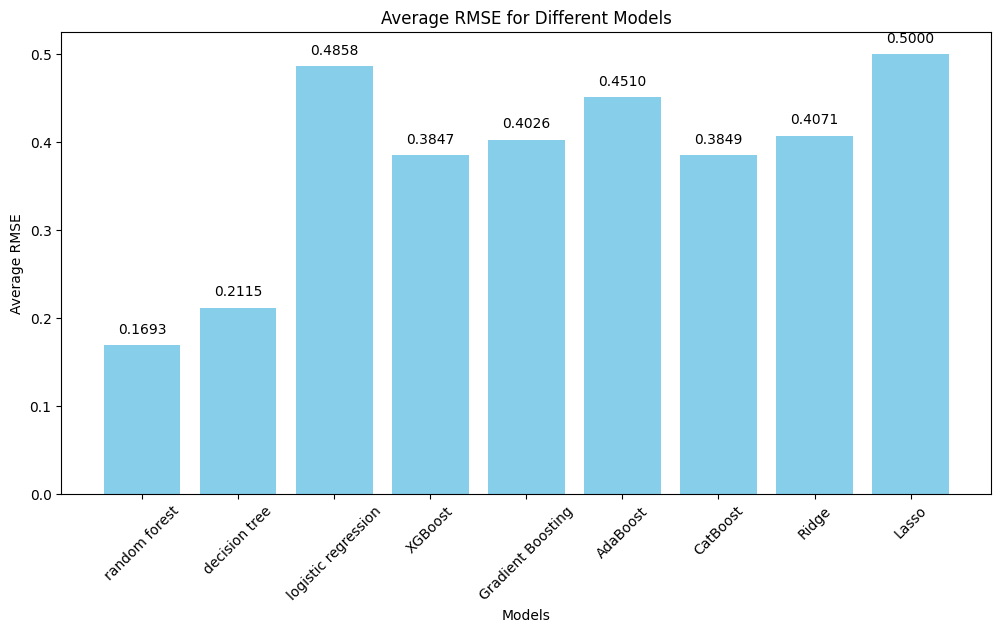

In [82]:
# Average RMSE for different models of heart_2022 
plot_rmse(models, average_rmses_2022)

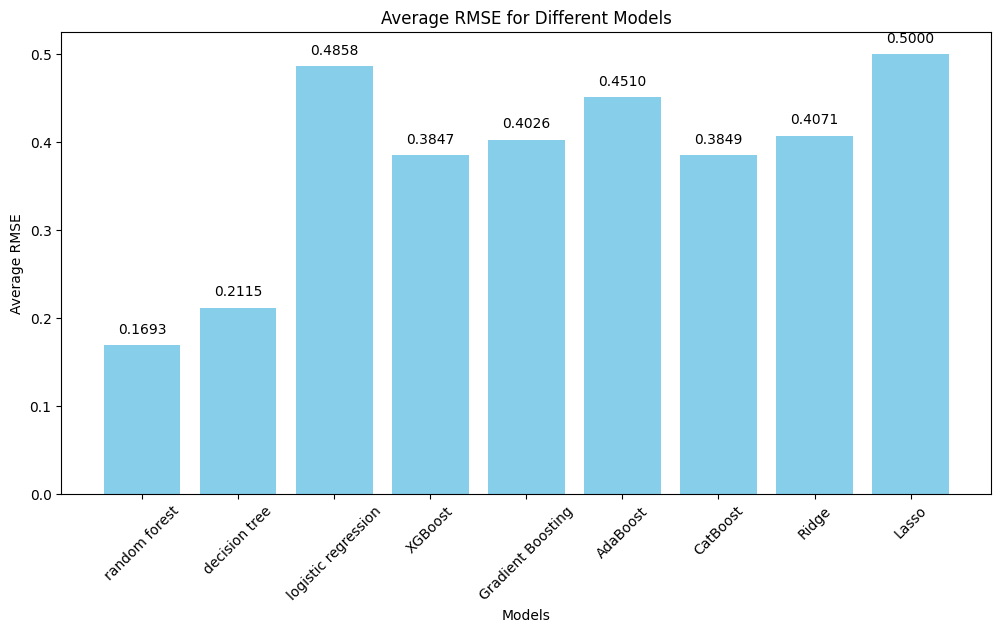

In [21]:
# Average RMSE for different models of heart_2020
plot_rmse(models, average_rmses)


In [83]:
average_rmses == average_rmses_2022

True

In [63]:
import pickle

# Save X_2020
with open('X_2020.pkl', 'wb') as file:
    pickle.dump(X_2020, file)
    print("success")

# Save y_2020
with open('y_2020.pkl', 'wb') as file:
    pickle.dump(y_2020, file)
    print("success")


success
success


## question
1. unbalanced dataset leading to the poorer performance to "YES", how to solve

raja: 
undersampling 
smote oversampling, make it balanced
meanwhile control the size of three datasets to make them close


3. we need other models, 
4. in previous study, how do they compare the importance of personal behaviors and accurate numbers


5. how to measure the formance of model,
--regression: rmse

question 0807
我有一个想法，不用那个小数据集，直接研究2020和2022的大数据集，研究影响心脏病的因素和影响因素的变化趋势--问问助教



Feature importance order:                                 Feature  Importance
0                                   BMI    0.275639
3                             SleepTime    0.078293
1                        PhysicalHealth    0.052517
2                          MentalHealth    0.051645
35                         Diabetic_Yes    0.045691
11                      DiffWalking_Yes    0.042424
10                       DiffWalking_No    0.042393
26              AgeCategory_80 or older    0.034049
24                    AgeCategory_70-74    0.027162
25                    AgeCategory_75-79    0.024956
23                    AgeCategory_65-69    0.020729
43                  GenHealth_Very good    0.018130
39                  GenHealth_Excellent    0.018095
22                    AgeCategory_60-64    0.015604
13                             Sex_Male    0.014446
12                           Sex_Female    0.012827
37                  PhysicalActivity_No    0.011856
38                 PhysicalActivity_Yes    0.011835
8                             Stroke_No    0.011190
32                           Race_White    0.011017
41                       GenHealth_Good    0.010131
5                           Smoking_Yes    0.009841
4                            Smoking_No    0.009802
9                            Stroke_Yes    0.009756
40                       GenHealth_Fair    0.009195
48                        SkinCancer_No    0.009041
45                           Asthma_Yes    0.009013
44                            Asthma_No    0.008960
49                       SkinCancer_Yes    0.008954
21                    AgeCategory_55-59    0.008938
29                           Race_Black    0.007954
30                        Race_Hispanic    0.007213
20                    AgeCategory_50-54    0.006678
42                       GenHealth_Poor    0.005997
7                   AlcoholDrinking_Yes    0.005378
6                    AlcoholDrinking_No    0.005362
47                    KidneyDisease_Yes    0.005345
46                     KidneyDisease_No    0.005322
31                           Race_Other    0.005045
19                    AgeCategory_45-49    0.004382
33                          Diabetic_No    0.003779
18                    AgeCategory_40-44    0.003709
34     Diabetic_No, borderline diabetes    0.003516
17                    AgeCategory_35-39    0.003410
27  Race_American Indian/Alaskan Native    0.003321
28                           Race_Asian    0.002799
16                    AgeCategory_30-34    0.002542
15                    AgeCategory_25-29    0.001729
14                    AgeCategory_18-24    0.001423
36      Diabetic_Yes (during pregnancy)    0.000965